In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import requests
import json
import folium
import pgeocode
import datetime

In [2]:
def read_covid_data():
    global latitude, longtitude, newly_confirmed_10, covid_data_frame
    longtitude = []
    latitude = []
    location_code = []

    base_url = "https://api.covid19api.com/summary"
    base_page = requests.get(base_url)

    covid_data = BeautifulSoup(base_page.content, 'html.parser')
    covid_json_data = json.loads(str(covid_data))

    covid_data_frame = pd.DataFrame.from_dict(covid_json_data['Countries'])
    covid_data_frame.set_index(keys = ['Country'], inplace = True, drop = False)
    newly_confirmed_10 = covid_data_frame.nlargest(10, "NewConfirmed")
    
    for country in newly_confirmed_10.CountryCode:
        geolocator = geolocator = Nominatim(user_agent = "Covid_world_wide_data")
        location = geolocator.geocode(country)
        latitude.append(location.latitude)
        longtitude.append(location.longitude)

    print(covid_data_frame.columns)
        
read_covid_data()

Index(['Country', 'CountryCode', 'Slug', 'NewConfirmed', 'TotalConfirmed',
       'NewDeaths', 'TotalDeaths', 'NewRecovered', 'TotalRecovered', 'Date',
       'Premium'],
      dtype='object')


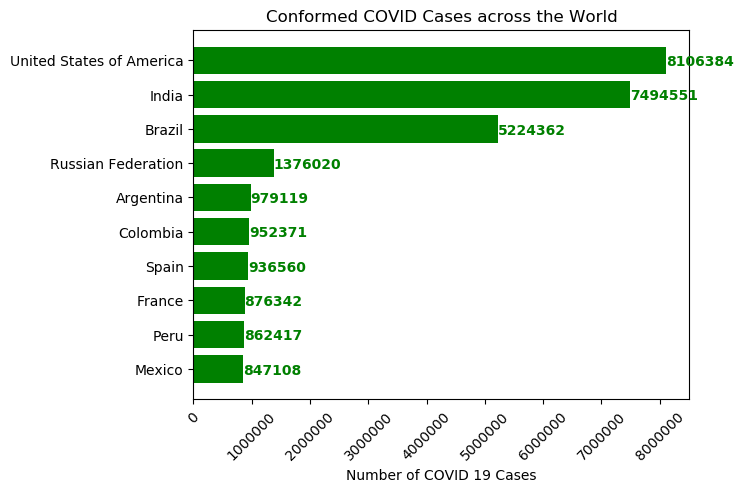

In [3]:
def total_confirmed(total_confirmed_covid_cases):
    x_axis = list(total_confirmed_covid_cases['Country'])
    y_axis = list(total_confirmed_covid_cases['TotalConfirmed'])
    plt.rcdefaults()
    fix, ax = plt.subplots()

    ax.barh(x_axis,y_axis, align='center', color = 'green', data = y_axis)
    plt.xticks(rotation=45)
    ax.invert_yaxis()
    ax.set_xlabel('Number of COVID 19 Cases')
    ax.set_title('Conformed COVID Cases across the World')
    for i, v in enumerate(y_axis):
        ax.text(v + 3, i + .15, str(v), color='green', fontweight='bold')
    plt.show()
total_confirmed(covid_data_frame.nlargest(10,'TotalConfirmed'))

In [4]:
def newly_confirmed():
    global m
    newly_confirmed_covid = pd.DataFrame({'latitude' : latitude,
                                        'longtitude' : longtitude,
                                         'country' : (newly_confirmed_10.Country).to_list(),
                                         'Newly_confirmed' : list(newly_confirmed_10.NewConfirmed)})
    m = folium.Map(location = [90, -90],
                    zoom_start = 2)
    
    for i in range(0,10):
       folium.Circle(
          location=[float(newly_confirmed_covid.iloc[i]['latitude']), float(newly_confirmed_covid.iloc[i]['longtitude'])],
          popup=str(newly_confirmed_covid.iloc[i]['country'])+" newly confirmed "+ str(newly_confirmed_covid.iloc[i]['Newly_confirmed']*10),
          radius=int(newly_confirmed_covid.iloc[i]['Newly_confirmed']*10),
          color='crimson',
          fill=True,
          fill_color='crimson'
       ).add_to(m)
    print(newly_confirmed_covid)
    
newly_confirmed()

    latitude  longtitude                   country  Newly_confirmed
0  22.351115   78.667743                     India            61871
1  39.783730 -100.445882  United States of America            57519
2 -10.333333  -53.200000                    Brazil            24062
3  54.702354   -3.276575            United Kingdom            16186
4  64.686314   97.745306        Russian Federation            14703
5 -34.996496  -64.967282                 Argentina            13510
6  50.640281    4.666715                   Belgium            10964
7  42.638426   12.674297                     Italy            10925
8  52.215933   19.134422                    Poland             9622
9  49.816700   15.474954            Czech Republic             8715


In [5]:
m

    Country CountryCode Province City CityCode Lat Lon    Cases     Status  \
0     India                                      0   0        1  confirmed   
1     India                                      0   0        1  confirmed   
2     India                                      0   0        1  confirmed   
3     India                                      0   0        2  confirmed   
4     India                                      0   0        3  confirmed   
..      ...         ...      ...  ...      ...  ..  ..      ...        ...   
257   India                                      0   0  7239389  confirmed   
258   India                                      0   0  7307097  confirmed   
259   India                                      0   0  7370468  confirmed   
260   India                                      0   0  7432680  confirmed   
261   India                                      0   0  7494551  confirmed   

                     Date  
0    2020-01-30T00:00:00Z  
1    20

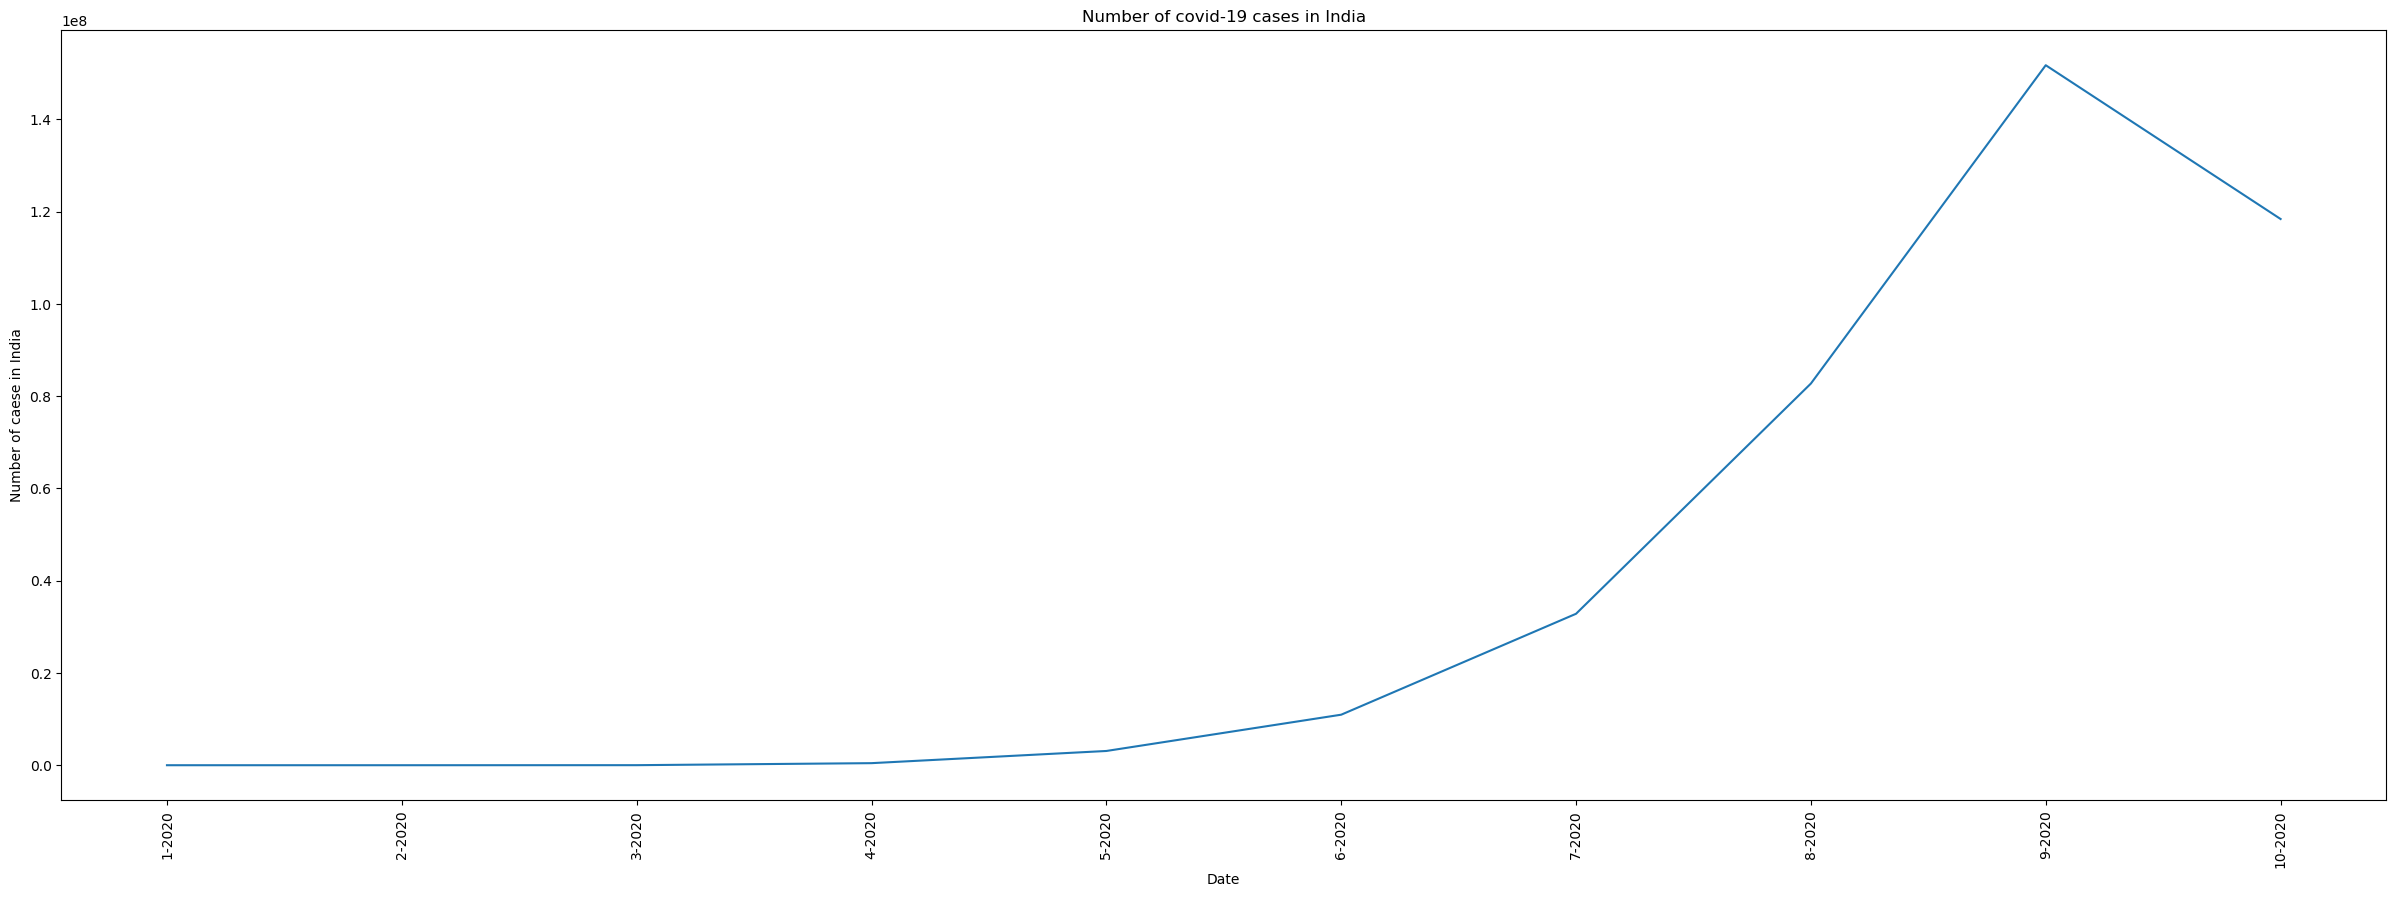

In [6]:
def india_covid_cases():
    global india_covid_dataframe
    base_url = "https://api.covid19api.com/total/dayone/country/india/status/confirmed"
    month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    base_india_covid_data = requests.get(base_url)
    base_india_covid_data = BeautifulSoup(base_india_covid_data.content,'html.parser')
    india_covid_data_json = json.loads(str(base_india_covid_data))
    india_covid_dataframe = pd.DataFrame.from_dict(india_covid_data_json)
    
    print(india_covid_dataframe)
    
    india_covid_dataframe.Date = pd.to_datetime(india_covid_dataframe.Date, dayfirst = True)
    
    india_covid_dataframe['Year'] = pd.DatetimeIndex(india_covid_dataframe['Date']).year
    india_covid_dataframe['Month'] = pd.DatetimeIndex(india_covid_dataframe['Date']).month
    month_wise_covid_data = india_covid_dataframe.groupby(by = ['Month', 'Year']).sum()
    month_wise_covid_data["Country"] = india_covid_dataframe.Country[0]
    
    Month_Year = []
    for month, year in month_wise_covid_data.index:
        Month_Year.append(str(month)+"-"+str(year))
    
    month_wise_covid_data['Month_Year'] = Month_Year
    print(month_wise_covid_data)
    plt.figure(figsize = [30,10])
    plt.subplot(1,1,1)
    plt.plot(month_wise_covid_data['Month_Year'], month_wise_covid_data['Cases'])
    plt.ylabel("Number of caese in India")
    plt.xlabel("Date")
    plt.xticks(rotation = 'vertical')
    plt.title("Number of covid-19 cases in India")
    
india_covid_cases()

[7552043.30917721 7630604.43037975 7709165.55158228 7787726.67278481
 7866287.79398734 7944848.91518988]


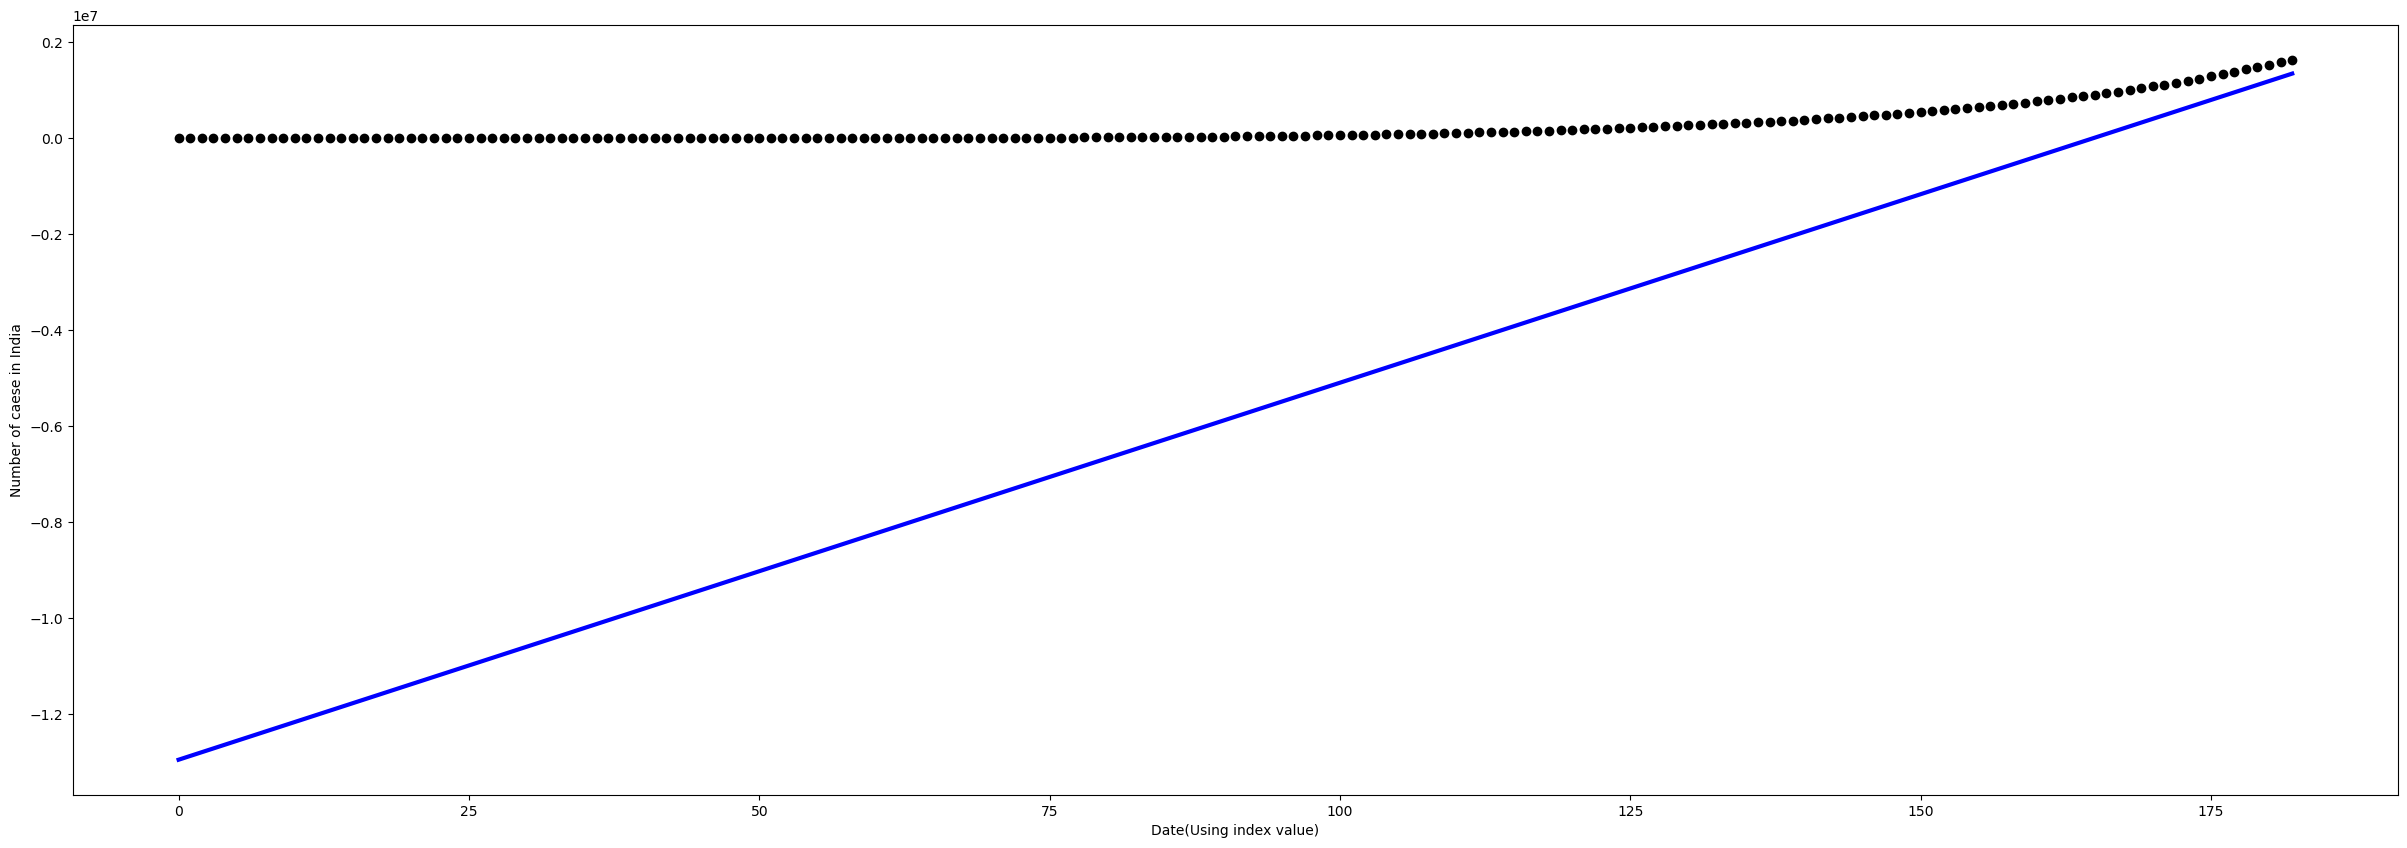

In [7]:
def covid_prdiction():
    x = india_covid_dataframe.index.to_numpy().reshape(-1, 1)
    y = (india_covid_dataframe['Cases']).to_numpy()
    
    _70 = int((len(x)/100)*70)
    
    x_train = x[_70:]
    x_test = x[:_70]
    
    y_train = y[_70:]
    y_test = y[:_70]
    
    regr = linear_model.LinearRegression()
    regr.fit(x_train, y_train)
    y_pred = regr.predict(x_test)    
    
    data = np.array([261, 262, 263, 264, 265, 266]).reshape((-1,1))
    print(regr.predict(data))
    
    plt.figure(figsize = (30, 10))

    plt.scatter(x_test, y_test,  color='black')
    plt.plot(x_test, y_pred, color='blue', linewidth=3)
    plt.ylabel("Number of caese in India")
    plt.xlabel("Date(Using index value)")
    plt.show()
    
covid_prdiction()